In [6]:
import math
import collections

import pandas as pd

from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import *

import params
from utils.sequence_data import data_to_sequences_and_labels
from utils.metrics import print_report_for_binary_classfier
from utils.preprocessing import probs_to_binary_classes
from utils.hyperparams import hyperparams_search
from utils.plot import plot_train_validation_metric

In [7]:
dataset = pd.read_csv("../datasets/data_for_models/dataset_1996-01-01_2019-08-22.csv",
                           header=0, parse_dates=[0], index_col=0)

input_shape = (params.LOOKBACK//params.STEP, dataset.shape[-1] )

In [8]:
#params for generating sequences 
train_max_idx = math.ceil(len(dataset)*params.TRAIN_RATIO)
val_max_idx = math.ceil(len(dataset)*(params.TRAIN_RATIO+params.VAL_RATIO))
label_index = len(dataset.columns) -1


# prepare data
train_X, train_Y = data_to_sequences_and_labels(dataset.to_numpy(), params.LOOKBACK, 
                                                params.STEP, 
                                                0, train_max_idx, 
                                                params.DELAY,
                                                label_index) 
val_X, val_Y = data_to_sequences_and_labels(dataset.to_numpy(), params.LOOKBACK, 
                                                params.STEP, 
                                                train_max_idx+1, val_max_idx, 
                                                params.DELAY,
                                                label_index)
test_X, test_Y = data_to_sequences_and_labels(dataset.to_numpy(), params.LOOKBACK, 
                                                params.STEP, 
                                                val_max_idx+1, None, 
                                                params.DELAY,
                                                label_index)

In [9]:
def lstm_model(hidden_unit, n_layer, l2_weight, input_shape):
    model = Sequential()
    is_return_sequences = True if n_layer>=2 else False
    
    # first layer
    model.add(LSTM(hidden_unit, 
                   input_shape=input_shape,
                   kernel_regularizer=regularizers.l2(l2_weight),
                   recurrent_regularizer=regularizers.l2(l2_weight),
                   return_sequences=is_return_sequences))
    
    # intermediate layers
    if n_layer >= 3:
        for _ in range(n_layer-2):
            model.add(LSTM(hidden_unit,
                           kernel_regularizer=regularizers.l2(l2_weight),
                           recurrent_regularizer=regularizers.l2(l2_weight),
                           return_sequences=is_return_sequences))

    
    # last layer
    if n_layer >= 2:
        model.add(LSTM(hidden_unit,
                       recurrent_regularizer=regularizers.l2(l2_weight),
                       kernel_regularizer=regularizers.l2(l2_weight)))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
best_params = hyperparams_search(model_func=lstm_model, 
                                 input_shape=input_shape,
                                 train_X=train_X, train_Y=train_Y, 
                                 val_X=val_X, val_Y=val_Y,
                                 num_epoch=1000,
                                 hidden_units=[32,64], 
                                 n_layers=[2,3], 
                                 l2_weights=[0,0.0001,0.001, 0.01],
                                 is_verbose=0)
print("\nbest params = {0}".format(best_params))

cur_avg_loss = 0.13620065772419157, cur_params = {'epochs': 134, 'n_layer': 2, 'hidden_unti': 32, 'l2_weight': 0}
cur_avg_loss = 0.16025324377241965, cur_params = {'epochs': 69, 'n_layer': 2, 'hidden_unti': 64, 'l2_weight': 0}
cur_avg_loss = 0.22090902806942148, cur_params = {'epochs': 89, 'n_layer': 3, 'hidden_unti': 32, 'l2_weight': 0}
cur_avg_loss = 0.13401763611095227, cur_params = {'epochs': 236, 'n_layer': 3, 'hidden_unti': 64, 'l2_weight': 0}
cur_avg_loss = 0.19087018440558642, cur_params = {'epochs': 63, 'n_layer': 2, 'hidden_unti': 32, 'l2_weight': 0.0001}
cur_avg_loss = 0.20839657280249269, cur_params = {'epochs': 174, 'n_layer': 2, 'hidden_unti': 64, 'l2_weight': 0.0001}
cur_avg_loss = 0.15615826731457016, cur_params = {'epochs': 81, 'n_layer': 3, 'hidden_unti': 32, 'l2_weight': 0.0001}
cur_avg_loss = 0.18950147541477194, cur_params = {'epochs': 65, 'n_layer': 3, 'hidden_unti': 64, 'l2_weight': 0.0001}
cur_avg_loss = 0.20283140018885054, cur_params = {'epochs': 118, 'n_layer

In [21]:
#hyperparameters
num_epoch = best_params['epochs'] 
n_layer= best_params['n_layer'] 
hidden_unit=best_params['hidden_unti']  
l2_weight=best_params['l2_weight']

model = lstm_model(hidden_unit, n_layer, l2_weight, input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

# #fit the model
history = model.fit(train_X, train_Y,
                    validation_data=(val_X, val_Y),
                    epochs=num_epoch,
                    verbose=1)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 15, 64)            25088     
_________________________________________________________________
lstm_47 (LSTM)               (None, 15, 64)            33024     
_________________________________________________________________
lstm_48 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 91,201
Trainable params: 91,201
Non-trainable params: 0
_________________________________________________________________
None
Train on 4033 samples, validate on 853 samples
Epoch 1/236
4033/4033 [==============================] - 9s 2ms/step - loss: 0.5280 - acc: 0.7630 - val_loss: 0.2497 - val_acc: 0.8933
Epoch 2/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.4883

4033/4033 [==============================] - 4s 1ms/step - loss: 0.1607 - acc: 0.9417 - val_loss: 0.7029 - val_acc: 0.7327
Epoch 55/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.1120 - acc: 0.9541 - val_loss: 0.8649 - val_acc: 0.6952
Epoch 56/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0646 - acc: 0.9755 - val_loss: 1.4994 - val_acc: 0.6471
Epoch 57/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0710 - acc: 0.9735 - val_loss: 0.6299 - val_acc: 0.8113
Epoch 58/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0538 - acc: 0.9777 - val_loss: 1.3274 - val_acc: 0.6835
Epoch 59/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0976 - acc: 0.9618 - val_loss: 0.9452 - val_acc: 0.7421
Epoch 60/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0560 - acc: 0.9789 - val_loss: 1.0232 - val_acc: 0.7339
Epoch 61/236
4033/4033 [==============================] - 4s 

4033/4033 [==============================] - 4s 1ms/step - loss: 0.0343 - acc: 0.9874 - val_loss: 1.2550 - val_acc: 0.7315
Epoch 115/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0250 - acc: 0.9903 - val_loss: 2.0344 - val_acc: 0.6424
Epoch 116/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0278 - acc: 0.9911 - val_loss: 1.0226 - val_acc: 0.7632
Epoch 117/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0275 - acc: 0.9896 - val_loss: 0.9257 - val_acc: 0.8007
Epoch 118/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0425 - acc: 0.9844 - val_loss: 1.1838 - val_acc: 0.7339
Epoch 119/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0201 - acc: 0.9923 - val_loss: 1.5826 - val_acc: 0.7163
Epoch 120/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0517 - acc: 0.9804 - val_loss: 1.5845 - val_acc: 0.7116
Epoch 121/236
4033/4033 [==============================

Epoch 174/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0166 - acc: 0.9936 - val_loss: 1.4875 - val_acc: 0.7479
Epoch 175/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0172 - acc: 0.9943 - val_loss: 1.1474 - val_acc: 0.8171
Epoch 176/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0091 - acc: 0.9958 - val_loss: 0.7993 - val_acc: 0.8242
Epoch 177/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0133 - acc: 0.9945 - val_loss: 2.0725 - val_acc: 0.6706
Epoch 178/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0430 - acc: 0.9841 - val_loss: 1.3470 - val_acc: 0.7503
Epoch 179/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0198 - acc: 0.9933 - val_loss: 1.7925 - val_acc: 0.6905
Epoch 180/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0153 - acc: 0.9943 - val_loss: 1.6211 - val_acc: 0.7268
Epoch 181/236
4033/4033 [================

Epoch 234/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0373 - acc: 0.9893 - val_loss: 1.0329 - val_acc: 0.8195
Epoch 235/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0327 - acc: 0.9864 - val_loss: 1.1574 - val_acc: 0.7479
Epoch 236/236
4033/4033 [==============================] - 4s 1ms/step - loss: 0.0060 - acc: 0.9985 - val_loss: 1.3965 - val_acc: 0.7186


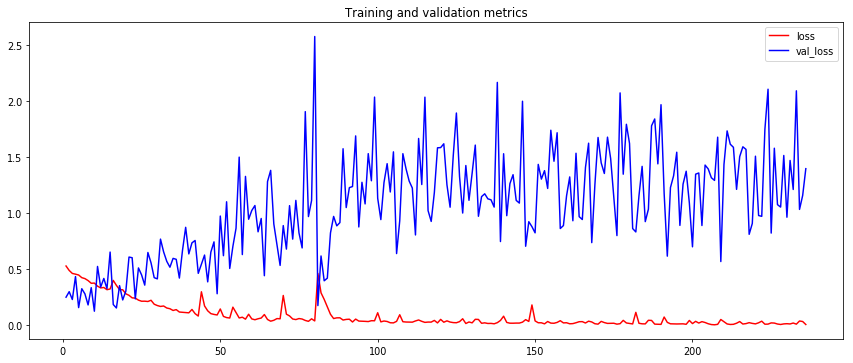

In [22]:
plot_train_validation_metric(history, 'loss', 'val_loss')

## We have 2984 positive and 984 negtive cases. 

In [23]:
#Make predictions for train set   
print(collections.Counter(train_Y))
print_report_for_binary_classfier(train_Y, probs_to_binary_classes(model.predict(train_X)))

Counter({0.0: 3049, 1.0: 984})
F1 score: 0.999492
precision score: 1.000000
recall score: 0.998984
accuracy score: 0.999752
matthews_corrcoef: 0.999328

Confusion matrix:
[[3049    0]
 [   1  983]]


In [24]:
#Make predictions from dev set
print(collections.Counter(val_Y))
print_report_for_binary_classfier(val_Y, probs_to_binary_classes(model.predict(val_X)))

Counter({0.0: 842, 1.0: 11})
F1 score: 0.083969
precision score: 0.043825
recall score: 1.000000
accuracy score: 0.718640
matthews_corrcoef: 0.177012

Confusion matrix:
[[602 240]
 [  0  11]]


In [25]:
#Make predictions for test set
print(collections.Counter(test_Y))
print_report_for_binary_classfier(test_Y, probs_to_binary_classes(model.predict(test_X)))

Counter({0.0: 811, 1.0: 30})
F1 score: 0.133333
precision score: 0.081481
recall score: 0.366667
accuracy score: 0.829964
matthews_corrcoef: 0.108006

Confusion matrix:
[[687 124]
 [ 19  11]]


# Save the best model

In [26]:
from keras.models import load_model

model.save(params.BEST_LSTM_MODEL_PATH)  # creates a HDF5 file 'my_model.h5'